Last modified Jul. 19, 2020 by Luis Valdivia

In [1]:
# we will need these eventually
import matplotlib.pyplot as plt 
import math

# 1.
# a.

First we write the code to compute the list of coeffcients for Newton’s form of the interpolation polynomial.

In [2]:
# INPUT: two lists x_j and f_j
# OUTPUT: the coefficients c_j for Newton’s form of the interpolation polynomial
def newton_coef(xj, fj):
    cj = []
    for i in range(len(xj)):
        cj.append(fj[i])
    for k in range(1, len(xj)):
        for j in range(len(xj)-1, k-1, -1):
            cj[j] = (cj[j] - cj[j-1])/(xj[j] - xj[j-k])
    return(cj)      

Then we write the code for evaluating the corresponding interpolation polynomial at an arbitrary point $x$.

In [3]:
# INPUT: the lists c_j and x_j from before, and a real value x
# OUTPUT: the interpolation polynomial evaluated at x
def inter_poly(cj, xj, x):
    p = cj[len(cj)-1]
    for j in range(len(xj)-2, -1, -1):
        p = cj[j] + ((x - xj[j]) * p);
    return(p)  

Let's test it by interpolating the polynomial $f(x) = x^2 -3x +4$ with $f(1) = 2$, $f(2) = 2$, and $f(3) = 4$. We will print the coefficients and then print the interpolating polynomial evaluated at $x = 4$ and $x = 5$.

In [4]:
testxj = [1,2,3]
testfj = [2,2,4]
testcj = newton_coef(testxj,testfj)
print(testcj)
print(inter_poly(testcj, testxj, 4))
print(inter_poly(testcj, testxj, 5))

[2, 0.0, 1.0]
8.0
14.0


The coefficients imply that the interpolating polynomial $p$ is $2 + (x-1)(x-2) = x^2 - 3x+4$, which agrees with $f(x)$. The other two results agree with $f(4) = 8$ and $f(5) = 14$. Thus, this test run has no errors and we can have a bit of confidence in this code.

# b.
Now we want to consider $f(x) = e^{-x^2}$, so we first need to code it.

In [5]:
# INPUT: a real-valued x
# OUTPUT: f(x)
def f(x):
    return(math.e ** (-x * x))

Now we code our node set in the interval $[-1,1]$.

In [6]:
# note set
n = []
for i in range(11):
    n.append(-1 + (2.0 * i / 10))

Then we use our functions from part (a) to get the interpolating polynomial evaluated at such nodes, storing this information in the list xbar.

In [7]:
# evaluate f at each node
fj = []
for i in n:
    fj.append(f(i))

# get Newton coefficients
cj = newton_coef(n, fj)

# to store the values of the interpolating polynomial at each node
xbar = []
for i in range(101):
    xbar.append(inter_poly(cj, n, -1 + (2.0 * i / 100)))

Now, we plot the error. 

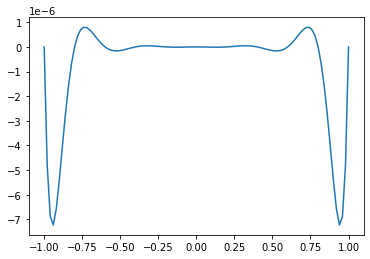

In [8]:
x_val = []
y_val = []
for i in range(101):
    x_val.append(-1 + (2.0 * i / 100))
    y_val.append(f(x_val[i]) - xbar[i])
plt.plot(x_val, y_val)

# 2.

See attached.

# 3.

We have the four interpolation points: $(0, 1), (1, 1), (2, 0), (3, 10)$. So, in total we must have at most 3 intervals for $x$. First we consider when $x \in [0,1)$. Then the slope must be

$$\frac{1-1}{1-0} = 0.$$

Putting this information into point-slope form for a line, we get $p_1 - 1 = 0$, or $p_1 = 1$.

Now, we consider when $x \in [1,2)$. Then the slope must be

$$\frac{0-1}{2-1} = -1.$$

Putting this information into point-slope form for a line, we get $p_2 = -(x-2)$, or $p_2 = 2 - x$.

Lastly, we consider when $x \in [2,3]$. Then the slope must be

$$\frac{10-0}{3-2} = 10.$$

Putting this information into point-slope form for a line, we get $p_3 - 0 = 10(x-2)$, or $p_3 = 10x - 20$.

Therefore, our piecewise linear function interpolating $(0, 1), (1, 1), (2, 0), (3, 10)$ is

$$p(x) = \begin{cases}
1, \quad x \in [0,1) \\
2 - x, \quad x \in [1,2) \\
10x - 20, \quad x \in [2,3] 
\end{cases}.$$

# 4.

Now we want to solve the tridiagonal system $Az = d$.

In [198]:
# INPUT: the two interpolating lists, x_i and f_i
# OUTPUT: the cubic splines for each interval
def nat_cubic_spline(xi, fi):
    # first we compute the values for a, b, c, d, and h and store them
    a = []
    b = []
    c = []
    d = []
    h = []
    for i in range(len(xi)-1):
        h.append(float(xi[i+1] - xi[i]))
        if(i > 0):
            if(i < len(xi) - 2):
                b.append(float(h[i]))
                c.append(float(h[i-1]))
            a.append(2.0 * (h[i-1] + h[i]))
            d.append((-6.0 * (fi[i] - fi[i-1]) / h[i-1]) + (6.0 * (fi[i+1] - fi[i]) / h[i]))
            
    # next, we determine the factorization coefficients
    m = [a[0]]
    l = []
    for i in range(len(xi) - 3):
        l.append(c[i] / m[i])
        m.append(a[i+1] - (l[i] * b[i]))
    
    # then, we do the forward substitution on Ly = d
    y = [d[0]]
    for i in range(1,len(xi)-2):
        y.append(d[i] - (l[i-1] * y[i-1]))
        
    # lastly, we do backward substitution to solve Uz = y
    z = [y[-1] / m[-1]]
    for i in range(len(xi)-3):
        z.insert(0, 0)
    for i in range(len(xi) - 4, -1, -1):
        z[i] = (y[i] - (b[i] * z[i+1])) / m[i]
    
    # since we are calculating, the natural spline, add 0's at the beginning and end
    z = [0] + z + [0] 
    
    # Now we calculate the coefficients
    for i in range(len(h)):
        print("s_",i,"(x)=", 
              (z[i+1]-z[i])/(6.0 * h[i]), "(x-", xi[i], ")^3 + (",
              (z[i] / 2.0), ")(x-", xi[i], ")^2 + (",
              ((fi[i+1] - fi[i])/(h[i])) - ((z[i+1] + 2 * z[i])* h[i] / 6.0), ")(x-", xi[i], ") + (",
              fi[i], ")", sep = "")

# 5.

We load in the data.

In [199]:
t = [0, 0.618, 0.935, 1.255, 1.636, 1.905, 2.317, 2.827, 3.330]
x = [1.50, 0.90, 0.60, 0.35, 0.20, 0.10, 0.50, 1.00, 1.50]
y = [0.75, 0.90, 1.00, 0.80, 0.45, 0.20, 0.10, 0.20, 0.25]

Now we calculate the two splines.

In [200]:
# note that these are functions of t in this case and s_i(x) = x
nat_cubic_spline(t,x) 

s_0(x)=0.010604214860542438(x-0)^3 + (0.0)(x-0)^2 + (-0.9749237905641648)(x-0) + (1.5)
s_1(x)=0.10119764748309755(x-0.618)^3 + (0.01966021435144568)(x-0.618)^2 + (-0.9627737780949713)(x-0.618) + (0.9)
s_2(x)=0.9715931590617196(x-0.935)^3 + (0.11589917710787148)(x-0.935)^2 + (-0.9178288761624392)(x-0.935) + (0.6)
s_3(x)=-1.7079822005314005(x-1.255)^3 + (1.0486286098071218)(x-1.255)^2 + (-0.5452958835267495)(x-1.255) + (0.35)
s_4(x)=5.288485038495574(x-1.636)^3 + (-0.903595045400269)(x-1.636)^2 + (-0.5113602105538169)(x-1.636) + (0.2)
s_5(x)=-3.134092233191061(x-1.905)^3 + (3.364212380665662)(x-1.905)^2 + (0.11681163760429725)(x-1.905) + (0.1)
s_6(x)=0.41395013380310053(x-2.317)^3 + (-0.5095256195584906)(x-2.317)^2 + (1.1325817930353892)(x-2.317) + (0.5)
s_7(x)=-0.08205307167677461(x-2.827)^3 + (0.12381808516025292)(x-2.827)^2 + (0.9525154540645321)(x-2.827) + (1.0)


In [201]:
# note that these are functions of t in this case and s_i(x) = y
nat_cubic_spline(t,y)

s_0(x)=0.289737015939865(x-0)^3 + (0.0)(x-0)^2 + (0.13206092652612478)(x-0) + (0.75)
s_1(x)=-3.1730809644688476(x-0.618)^3 + (0.5371724275525097)(x-0.618)^2 + (0.4640334867535758)(x-0.618) + (0.9)
s_2(x)=2.605653470243342(x-0.935)^3 + (-2.480427569657365)(x-0.935)^2 + (-0.09808209306256177)(x-0.935) + (1.0)
s_3(x)=-0.3032323821519493(x-1.255)^3 + (0.020999761776241795)(x-1.255)^2 + (-0.8826185640148636)(x-1.255) + (0.8)
s_4(x)=2.1740063481666834(x-1.636)^3 + (-0.32559485102343627)(x-1.636)^2 + (-0.9990962881741616)(x-1.636) + (0.45)
s_5(x)=-0.6887645842772723(x-1.905)^3 + (1.428828271947078)(x-1.905)^2 + (-0.7144820390505766)(x-1.905) + (0.2)
s_6(x)=-0.5477829806449837(x-2.317)^3 + (0.5775152457803692)(x-2.317)^2 + (0.04402400929032105)(x-2.317) + (0.1)
s_7(x)=0.17269232246948663(x-2.827)^3 + (-0.2605927146064554)(x-2.827)^2 + (0.1867890021601917)(x-2.827) + (0.2)


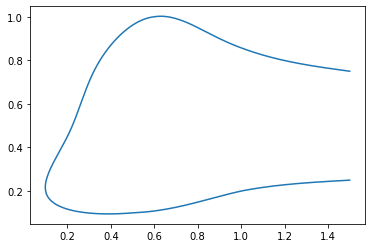

In [205]:
t_val = []
x_val = []
y_val = []
for i in range(1001):
    t_val.append(3.330 * i / 1000)
    # s_0
    if (t_val[i] >= t[0] and t_val[i] < t[1]):
        x_val.append((0.010604214860542438 * (t_val[i] ** 3)) + (-0.9749237905641648 * t_val[i]) + (1.5))
        y_val.append((0.289737015939865 * (t_val[i] ** 3)) + (0.13206092652612478 * t_val[i]) + (0.75))
    #s_1
    elif (t_val[i] >= t[1] and t_val[i] < t[2]):
        x_val.append((0.10119764748309755 * ((t_val[i]-0.618) ** 3)) + (0.01966021435144568 * ((t_val[i]-0.618) ** 2)) + (-0.9627737780949713 * (t_val[i]-0.618)) + (0.9))
        y_val.append((-3.1730809644688476 * ((t_val[i]-0.618) ** 3)) + (0.5371724275525097 * ((t_val[i]-0.618) ** 2)) + (0.4640334867535758 * (t_val[i]-0.618)) + (0.9))
    #s_2
    elif (t_val[i] >= t[2] and t_val[i] < t[3]):
        x_val.append((0.9715931590617196 * ((t_val[i]-0.935) ** 3)) + (0.11589917710787148 * ((t_val[i]-0.935) ** 2)) + (-0.9178288761624392 * (t_val[i]-0.935)) + (0.6))
        y_val.append((2.605653470243342 * ((t_val[i]-0.935) ** 3)) + (-2.480427569657365 * ((t_val[i]-0.935) ** 2)) + (-0.09808209306256177 * (t_val[i]-0.935)) + (1.0))
    #s_3
    elif (t_val[i] >= t[3] and t_val[i] < t[4]):
        x_val.append((-1.7079822005314005 * ((t_val[i]-1.255) ** 3)) + (1.0486286098071218 * ((t_val[i]-1.255) ** 2)) + (-0.5452958835267495 * (t_val[i]-1.255)) + (0.35))
        y_val.append((-0.3032323821519493 * ((t_val[i]-1.255) ** 3)) + (0.020999761776241795 * ((t_val[i]-1.255) ** 2)) + (-0.8826185640148636 * (t_val[i]-1.255)) + (0.8))
    #s_4
    elif (t_val[i] >= t[4] and t_val[i] < t[5]):
        x_val.append((5.288485038495574 * ((t_val[i]-1.636) ** 3)) + (-0.903595045400269 * ((t_val[i]-1.636) ** 2)) + (-0.5113602105538169 * (t_val[i]-1.636)) + (0.2))
        y_val.append((2.1740063481666834 * ((t_val[i]-1.636) ** 3)) + (-0.32559485102343627 * ((t_val[i]-1.636) ** 2)) + (-0.9990962881741616 * (t_val[i]-1.636)) + (0.45))
    #s_5
    elif (t_val[i] >= t[5] and t_val[i] < t[6]):
        x_val.append((-3.134092233191061 * ((t_val[i]-1.905) ** 3)) + (3.364212380665662 * ((t_val[i]-1.905) ** 2)) + (0.11681163760429725 * (t_val[i]-1.905)) + (0.1))
        y_val.append((-0.6887645842772723 * ((t_val[i]-1.905) ** 3)) + (1.428828271947078 * ((t_val[i]-1.905) ** 2)) + (-0.7144820390505766 * (t_val[i]-1.905)) + (0.2))
    #s_6
    elif (t_val[i] >= t[6] and t_val[i] < t[7]):
        x_val.append((0.41395013380310053 * ((t_val[i]-2.317) ** 3)) + (-0.5095256195584906 * ((t_val[i]-2.317) ** 2)) + (1.1325817930353892 * (t_val[i]-2.317)) + (0.5))
        y_val.append((-0.5477829806449837 * ((t_val[i]-2.317) ** 3)) + (0.5775152457803692 * ((t_val[i]-2.317) ** 2)) + (0.04402400929032105 * (t_val[i]-2.317)) + (0.1))
    #s_7
    elif (t_val[i] >= t[7] and t_val[i] <= t[8]):
        x_val.append((-0.08205307167677461 * ((t_val[i]-2.827) ** 3)) + (0.12381808516025292 * ((t_val[i]-2.827) ** 2)) + (0.9525154540645321 * (t_val[i]-2.827)) + (1.0))
        y_val.append((0.17269232246948663 * ((t_val[i]-2.827) ** 3)) + (-0.2605927146064554 * ((t_val[i]-2.827) ** 2)) + (0.1867890021601917 * (t_val[i]-2.827)) + (0.2))
plt.plot(x_val, y_val)